In [2]:
import pandas as pd
import numpy as np
#import geopandas as gpd
#from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv("foia_150k_plus.csv")

In [3]:
#us_map = gpd.read_file("cb_2018_us_cbsa_20m.shp")

In [4]:
#us_map.plot()

In [4]:
df['LoanRange'].unique()

array(['a $5-10 million', 'b $2-5 million', 'c $1-2 million',
       'd $350,000-1 million', 'e $150,000-350,000'], dtype=object)

In [6]:
# Original dataset has 661,218 firms?

df.shape

(661218, 16)

In [6]:
# missing data for 2 weeks

df[df['DateApproved']== '04/18/2020'].index  

Int64Index([], dtype='int64')

In [7]:
# Only 656,593 unique firm names

len(df['BusinessName'].unique())

656593

In [8]:
# Drop 5 rows with businessname == 'Not Available'

df = df[df['BusinessName']!= 'NOT AVAILABLE']

# New number of unique firms = 656,592

len(df['BusinessName'].unique())


656592

In [9]:
# Loan Range is categorical value, need to convert to numerical
# Mean loan value used for each bin

df['LoanRange'] = df['LoanRange'].replace({'a $5-10 million': 7.5, 'b $2-5 million': 3.5, 'c $1-2 million': 1.5,
                                          'd $350,000-1 million': 0.675, 'e $150,000-350,000': 0.25})


In [10]:
df['LoanRange'].unique()

array([7.5  , 3.5  , 1.5  , 0.675, 0.25 ])

In [12]:
df['BusinessName'] = df['BusinessName'].astype(str)
df['NAICSCode'] = df['NAICSCode'].astype(str)

In [12]:
#df.to_csv('ppp_clean.csv')

# Cleaned df

In [79]:
df = pd.read_csv('ppp_clean.csv')

In [80]:
# Check no nil state values
df[df['State'] == "XX"] 

,Unnamed: 0,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD


In [81]:
del df['Unnamed: 0']

# Pivot by Date Approved, and LoanRange to track loans to different NAICS industry over time

x = df.pivot_table(values= 'LoanRange',
              index= 'DateApproved',
              columns= 'NAICSCode',
              aggfunc= np.sum)

# clean up data- rename column, replace NaN with 0 values

x = x.unstack().reset_index()
x = x.rename(columns= {0:'Loan Amt'})
x = x.fillna(0)

# Get rid of crazy NAICS codes

x = x[x['NAICSCode']!= 999990.0]

# Convert codes to string for ease of querying

x['NAICSCode'] = x['NAICSCode'].astype(str)

In [82]:
# For Joe, investigate other health practitioners sector code= 6213

#us_othr = df[df['NAICSCode'].str.contains('6213')]
#ny_othr = us_othr[us_othr['State']== 'NY']
#ny_othr.describe()

In [83]:
x

,NAICSCode,DateApproved,Loan Amt
0,111110.0,04/03/2020,0.250
1,111110.0,04/04/2020,1.000
2,111110.0,04/05/2020,1.925
3,111110.0,04/06/2020,2.675
4,111110.0,04/07/2020,1.425
...,...,...,...
92109,928120.0,06/26/2020,0.000
92110,928120.0,06/27/2020,0.000
92111,928120.0,06/28/2020,0.000
92112,928120.0,06/29/2020,0.000


## Plot PPP loans trend over time by industry

In [84]:
# Get index with all industires beginning with 2-digit NAICS code 
# Use it to filter out main df

def by_ind(naics):
    fil_ind = list(pd.Series(x['NAICSCode']).str.startswith(naics))
    output = x.loc[fil_ind, :]
    output = output.groupby(["DateApproved"]).sum()    # Aggregate by date 
    output = output.reset_index()
    output['DateApproved'] = pd.to_datetime(output['DateApproved'])
    return output


In [85]:
health = by_ind('62')
manu = by_ind('3')
const = by_ind('23')

In [86]:
# Compile a tuple of all industry codes to drop

exclude_ind = (str(3), str(23), str(62))

In [87]:
# Get index of industries to drop

fil_ind = list(pd.Series(x['NAICSCode']).str.startswith(exclude_ind))
ind = x.loc[fil_ind, :]

In [88]:
# drop index representing 3 industries from main df - 23(Const), 3(Manu), 62(Health)

other_ind = x.drop(ind.index)

In [89]:
# Check if there are nil industry codes, if so get their index and other_ind.drop(index, inplace = True)

any(other_ind['NAICSCode']== '0')

False

In [60]:
any(other_ind['NAICSCode']== 'NaN')

False

In [66]:
any(other_ind['NAICSCode']== '999990.0')

False

In [61]:
# Check if there r nil loan amounts, yes

any(other_ind['Loan Amt']== 0)

True

In [90]:
# Drop them like its hot

drop_index = other_ind[other_ind['Loan Amt']== 0].index
other_ind.drop(drop_index, inplace=True)

In [91]:
any(other_ind['Loan Amt']== 0)

False

In [92]:
other_ind['DateApproved'] = pd.to_datetime(other_ind['DateApproved'])

## Plot the final graph

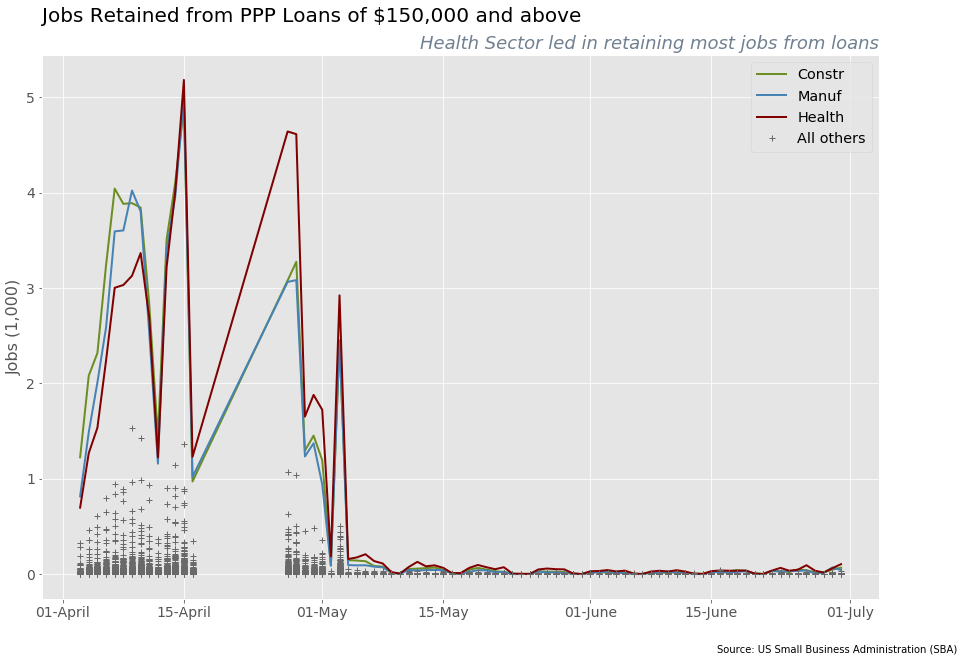

In [93]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

myFmt = mdates.DateFormatter('%d-%B')

def per(x, pos):
    return '%1.0f' % (x * 1e-3)
formatter = FuncFormatter(per)

fig = plt.figure(figsize=(15,10))

plt.title('Jobs Retained from PPP Loans of $150,000 and above', fontsize=20, loc= 'left', y=1.05)
plt.title('Health Sector led in retaining most jobs from loans', fontsize= 18, loc= 'right', color='slategrey', style='italic')

plt.plot(const['DateApproved'], const['Loan Amt'], color='olivedrab', linewidth=2)
plt.plot(manu['DateApproved'], manu['Loan Amt'], color='steelblue', linewidth=2)
plt.plot(health['DateApproved'], health['Loan Amt'], color='maroon', linewidth=2)
plt.plot(other_ind['DateApproved'], other_ind['Loan Amt'], '+', color='dimgrey')
plt.legend(['Constr', 'Manuf', 'Health', 'All others'], fontsize='x-large')
plt.yticks(fontsize= 14)
plt.xticks(fontsize= 14)

plt.ylabel('Jobs (1,000)', fontsize=16)
plt.rcParams["font.family"] = "sans-serif"
ax = fig.text(.75, .05, 'Source: US Small Business Administration (SBA)', fontsize= 10)

ax = fig.gca()
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(myFmt)

## Investigate effectiveness of loans in retaining jobs
Take the cumulative amount of loans for each of the 3 sector and calculate cumulative amount of jobs retained

In [110]:
c['Jobs Retained'].sum()

3169146.0

In [111]:
m['Jobs Retained'].sum()

3444894.0

In [112]:
h['Jobs Retained'].sum()

4807060.0

In [140]:
zz['Jobs Retained'].sum()

19593955.0

In [126]:
# Loans dispensed
c['Loan Amt'].sum()

56998.25000000005

In [127]:
m['Loan Amt'].sum()

52714.975000000006

In [128]:
h['Loan Amt'].sum()

56342.449999999946

In [163]:
zz['Loan Amt'].sum()

261364.5249999999

In [134]:
# Construction no. of jobs retained for each Million$

3169146.0/ 56998.25000000005

55.60075967244603

In [135]:
# Manufacturing

3444894.0/ 52714.975000000006

65.3494381814655

In [136]:
# Health

4807060.0/ 56342.449999999946

85.31861855492625

In [164]:
# other sectors

19593955.0/261364.5249999999

74.96792076124335

In [170]:
df = {'Sector': ['Construction', 'Manufacturing', 'Health', 'All Other Sectors (avg)'], 
      'Jobs Retained/ Million ($ USD) Spent': [56, 65, 85, 75]}

In [171]:
df = pd.DataFrame(df)

In [172]:
df

,Sector,Jobs Retained/ Million ($ USD) Spent
0,Construction,56
1,Manufacturing,65
2,Health,85
3,All Other Sectors (avg),75


In [229]:
import seaborn as sns

In [231]:
colors = ["#95a5a6", "#3498db", "#e74c3c", "#34495e"]
customPalette = sns.set_palette(sns.color_palette(colors))

Text(0.5, 1.0, 'No. of Jobs Retained/ Million ($USD) PPP Loan')

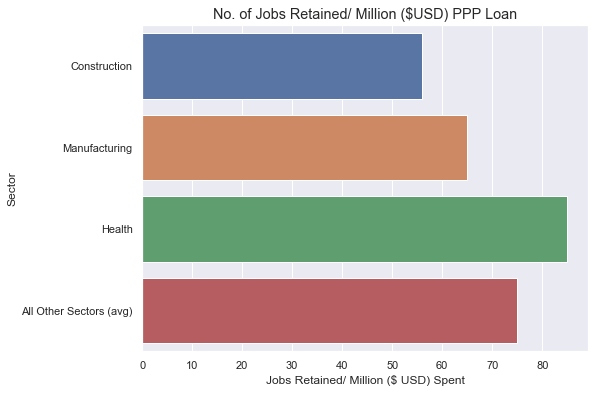

In [228]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x="Jobs Retained/ Million ($ USD) Spent", y="Sector", palette=customPalette, data=df)

ax.set_title('No. of Jobs Retained/ Million ($USD) PPP Loan', fontsize= 'large')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.fig.text(.75, .05, 'Source: US Small Business Administration (SBA)', fontsize= 10)

Text(0.95, -0.1, 'Source: US Small Business Administration (SBA)')

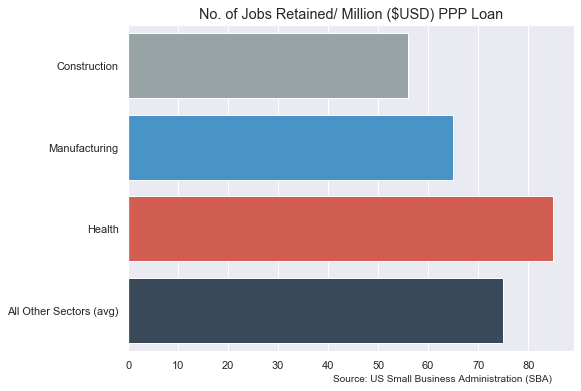

In [241]:
ax = sns.barplot(x="Jobs Retained/ Million ($ USD) Spent", y="Sector", palette=customPalette, data=df)

ax.set_title('No. of Jobs Retained/ Million ($USD) PPP Loan', fontsize= 'large')
ax.set_ylabel('')    
ax.set_xlabel('')

ax.text(0.95, -0.1, "Source: US Small Business Administration (SBA)", ha="right", va="bottom", transform=ax.transAxes, fontsize= 10)
